<a href="https://colab.research.google.com/github/ap4ashutosh/Face-recognition-using-Siamese-Network/blob/main/Face_detection_model_using_siamese_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install tensorflow-gpu

In [2]:
!nvidia-smi

Sat Dec  9 12:10:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import tensorflow as tf
from tensorflow import keras

In [5]:
#Import tensorflow dependencies functional api
from keras.models import Model
from keras.layers import Input, Layer, Conv2D, Dense, MaxPool2D, Flatten

In [6]:
#Avoid out of memory error
gpus = tf.config.experimental.list_physical_devices('GPU')
for g in gpus:
  tf.config.experimental.set_memory_growth(g, True)

In [7]:
for g in gpus:
  print(g)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [8]:
pos_path = os.path.join(r'/content/drive/MyDrive', 'data', 'positive')
neg_path = os.path.join(r'/content/drive/MyDrive', 'data', 'negative')
anc_path = os.path.join(r'/content/drive/MyDrive', 'data', 'anchor')

In [9]:
from glob import glob
folder = glob(r'/content/drive/MyDrive/data')

In [10]:
anchor = tf.data.Dataset.list_files('/content/drive/MyDrive/data/anchor/*.jpg').take(300)
positive = tf.data.Dataset.list_files('/content/drive/MyDrive/data/positive/*.jpg').take(300)
negative = tf.data.Dataset.list_files('/content/drive/MyDrive/data/negative/*.jpg').take(300)

In [11]:
def preprocess(file_path):
    # reading byte images from path
    byte_img = tf.io.read_file(file_path)
    # decoding image to load actual image
    img = tf.io.decode_jpeg(byte_img)
    # preprocessing steps
    img = tf.image.resize(img, (100, 100))
    # scaling image to be in range 0 to 1
    img = img/255.0
    return img

In [12]:
#Grabbing content example
test_folder = anchor.as_numpy_iterator()
print(test_folder.next())
print(type(test_folder.next()))

b'/content/drive/MyDrive/data/anchor/93c2068c-8067-11ee-8834-387a0e1eae87.jpg'
<class 'bytes'>


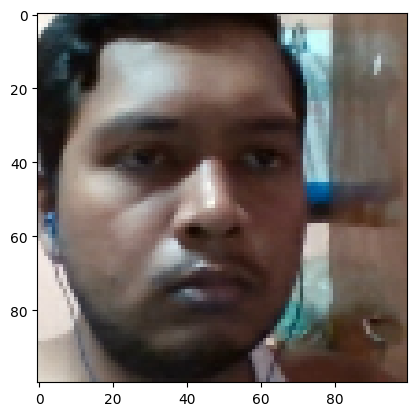

In [13]:
img = preprocess(test_folder.next())
plt.imshow(img);

In [14]:
# (anchor, positive) => 1,1,1,1
# (anchor, negative) => 0,0,0,0

positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(negative)))))
data = positives.concatenate(negatives)

In [15]:
data

<_ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [16]:
class_labels = tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))
iterator_labs = class_labels

In [17]:
def preprocess_twin(input_img, validation_img, label):
    return (preprocess(input_img), preprocess(validation_img),label)

In [18]:
samples = data.as_numpy_iterator()

In [19]:
example = samples.next()
example

(b'/content/drive/MyDrive/data/anchor/3630d0cf-805f-11ee-9e21-387a0e1eae87.jpg',
 b'/content/drive/MyDrive/data/positive/d11940a0-8067-11ee-9b74-387a0e1eae87.jpg',
 1.0)

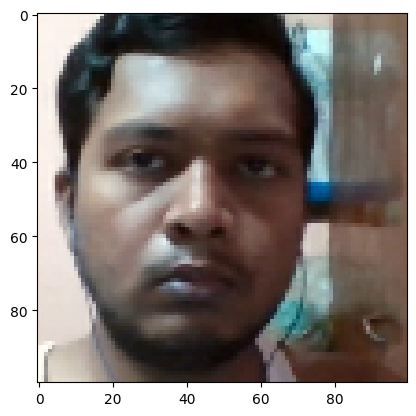

In [20]:
result = preprocess_twin(*example)
plt.imshow(result[0])
plt.imshow(result[1])
# plt.imshow(result[2])

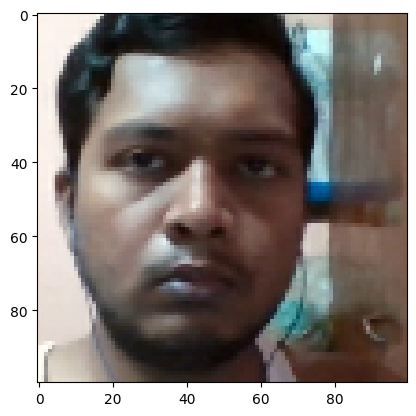

In [21]:
plt.imshow(result[1])

In [22]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size = 1024)

In [23]:
train_data = data.take(round(len(data) * 0.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [24]:
train_sample = train_data.as_numpy_iterator()
train_sample

In [25]:
# print(len(train_sample.next()[0])) #Batch Size

In [26]:
test_data = data.skip(round(len(data) * 0.7))
test_data = data.take(round(len(data) * 0.3))

In [27]:
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [28]:
def make_embedding():
    # ------------------------------
    #          FIRST BLOCK
    # ------------------------------
    ip = Input(shape = (100,100,3), name='input_image')
    c1 = Conv2D(64,10,activation='relu')(ip)
    m1 = MaxPool2D(64, 2, padding = 'same')(c1)
    # ------------------------------
    #          SECOND BLOCK
    # ------------------------------
    c2 = Conv2D(128,7,activation = 'relu')(m1)
    m2 = MaxPool2D(64,2,padding='same')(c2)
    # ------------------------------
    #          THIRD BLOCK
    # ------------------------------
    c3 = Conv2D(128,4,activation = 'relu')(m2)
    m3 = MaxPool2D(64,2,padding='same')(c3)
    # ------------------------------
    #          FINAL BLOCK
    # ------------------------------
    c4 = Conv2D(256,4,activation = 'relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation = 'sigmoid')(f1)
    return Model(inputs = [ip], outputs =[d1], name ='embedding')

In [29]:
embedding = make_embedding()

In [30]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 46, 46, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [31]:
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()

    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [35]:
def make_siamese_model():
    # Handle inputs
    input_image = Input(name = 'input_img', shape=(100,100,3))
    validation_image = Input(name = 'validation_img', shape=(100,100,3))
    # Combine the siamese and distance components
    siamese_layer = L1Dist()
    # siamese_layer.name = 'distance1'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    # Classifier layer
    classifier = Dense(1,activation='sigmoid')(distances)

    return Model(inputs = [input_image, validation_image], outputs = classifier, name = 'SiameseNetwork')

In [36]:
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4)

In [38]:
checkpoint_dir = r'./training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt') #all checkpoints will start from ckpt to make it consistent
siamese_model = make_siamese_model()
checkpoint = tf.train.Checkpoint(opt = opt, siamese_model = siamese_model)

In [39]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [40]:
test_batch = train_data.as_numpy_iterator()
batch1 = test_batch.next()
print(len(batch1[0]))
batch1[0]

16


array([[[[0.9845588 , 0.95710784, 0.9257353 ],
         [0.98137254, 0.95392156, 0.922549  ],
         [0.9843137 , 0.95686275, 0.9254902 ],
         ...,
         [0.5019608 , 0.4       , 0.3392157 ],
         [0.5002451 , 0.39828432, 0.33161765],
         [0.49926472, 0.3973039 , 0.33063725]],

        [[0.99019605, 0.9607843 , 0.93039215],
         [0.9892157 , 0.95980394, 0.92941177],
         [0.9892157 , 0.95980394, 0.92941177],
         ...,
         [0.47745097, 0.3882353 , 0.327451  ],
         [0.49044117, 0.4019608 , 0.3389706 ],
         [0.49068627, 0.40441176, 0.33995098]],

        [[0.9892157 , 0.95980394, 0.92941177],
         [0.9889706 , 0.95955884, 0.9291667 ],
         [0.9852941 , 0.9558824 , 0.9254902 ],
         ...,
         [0.4752451 , 0.39191177, 0.32818627],
         [0.4852941 , 0.40269607, 0.3367647 ],
         [0.49338236, 0.41887254, 0.35220587]],

        ...,

        [[0.7497549 , 0.6997549 , 0.6389706 ],
         [0.7289216 , 0.6816176 , 0.6372549 ]

In [41]:
batch1[1]

array([[[[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        ...,

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]

In [42]:
print(len(batch1[2]))
batch1[2]

16


array([0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0.],
      dtype=float32)

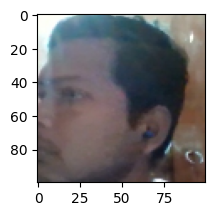

In [43]:
plt.subplot(2,2,2)
plt.imshow(batch1[1][1])
plt.imshow(batch1[0][1])

In [44]:
@tf.function
def train_step(batch):
    # record the graddients
    with tf.GradientTape() as tape:
        # Get anchor and positive/negative images
        x = batch[:2]
        # Get label
        y = batch[2]
        # Forward pass
        yhat = siamese_model(x,training = True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    # Calculate updated weights and apply to the siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    return loss

In [45]:
def train(data, EPOCHS):
    # loop through epochs
    for epoch in range(1, EPOCHS+1):
        print(f'\n Epoch {epoch}/{EPOCHS}')
        progbar = tf.keras.utils.Progbar(len(data))
        # loop through each batch
        for idx, batch in enumerate(data):
            train_step(batch)
            progbar.update(idx + 1)
    # Save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [46]:
Epochs = 50

In [47]:
train(train_data,Epochs)


 Epoch 1/50
27/27 [==============================] - 20s 196ms/step

 Epoch 2/50
27/27 [==============================] - 5s 180ms/step

 Epoch 3/50
27/27 [==============================] - 5s 181ms/step

 Epoch 4/50
27/27 [==============================] - 5s 182ms/step

 Epoch 5/50
27/27 [==============================] - 5s 182ms/step

 Epoch 6/50
27/27 [==============================] - 5s 183ms/step

 Epoch 7/50
27/27 [==============================] - 5s 182ms/step

 Epoch 8/50
27/27 [==============================] - 5s 183ms/step

 Epoch 9/50
27/27 [==============================] - 5s 184ms/step

 Epoch 10/50
27/27 [==============================] - 5s 185ms/step

 Epoch 11/50
27/27 [==============================] - 5s 191ms/step

 Epoch 12/50
27/27 [==============================] - 5s 187ms/step

 Epoch 13/50
27/27 [==============================] - 5s 188ms/step

 Epoch 14/50
27/27 [==============================] - 5s 186ms/step

 Epoch 15/50
27/27 [=====================

In [49]:
# Import the test metrics
from keras.metrics import Precision, Recall

In [50]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [51]:
predictions = siamese_model.predict([test_input, test_val])

1/1 [==============================] - 0s 214ms/step


In [52]:
y_hat = predictions

In [53]:
y_hat

array([[1.0000000e+00],
       [9.9968743e-01],
       [1.0000000e+00],
       [9.9428058e-01],
       [1.0000000e+00],
       [9.9760264e-01],
       [1.0000000e+00],
       [6.0673432e-12],
       [9.9999011e-01],
       [1.6119451e-08],
       [9.9687529e-01],
       [1.4030412e-11],
       [9.6173167e-11],
       [1.0000000e+00],
       [7.9310243e-14],
       [9.9949026e-01]], dtype=float32)

In [55]:
# Convert yhat to binary 01 representation
y_hat_ls = [1 if p > 0.5 else 0 for p in y_hat]

In [56]:
y_hat_ls

[1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1]

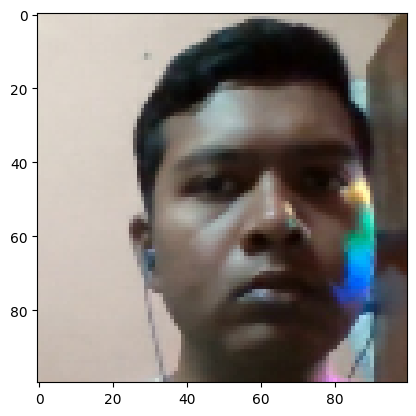

In [57]:
plt.imshow(test_input[0]) #as 0 pos is 1 so let's see what's in there

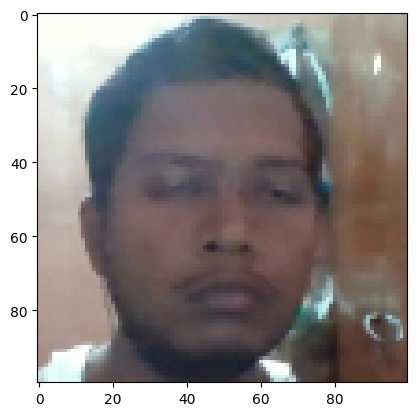

In [58]:
plt.imshow(test_val[0])

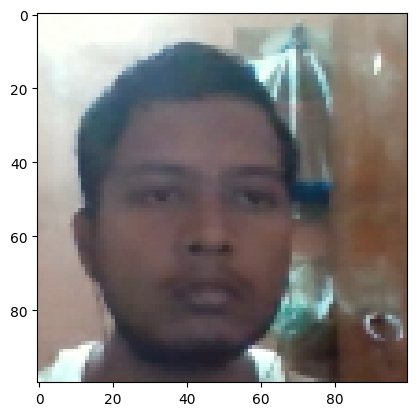

In [59]:
plt.imshow(test_input[7]) # 7th item showing false so let's see

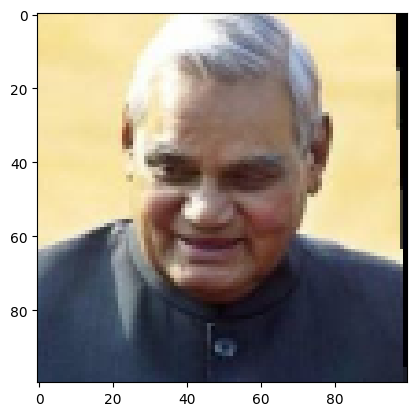

In [60]:
plt.imshow(test_val[7]) # As u can see it is not me this is  Shree atal ji

In [61]:
print(y_true)
print(y_hat_ls)

[1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1.]
[1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1]


In [63]:
# creating metric object of precision
m = Precision()
m.update_state(y_true, y_hat_ls)
m.result().numpy()

1.0

In [64]:
# creating metric object of precision
m1 = Recall()
m1.update_state(y_true, y_hat_ls)
m1.result().numpy()

1.0

The above shows 100% precision and 100% recall

Let's run it on another batch and see

In [72]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()
y_hat = siamese_model.predict([test_input, test_val])
y_hat_ls = [1 if p > 0.5 else 0 for p in y_hat]

1/1 [==============================] - 0s 30ms/step


In [73]:
print(y_true)
print(y_hat_ls)

[0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0.]
[0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0]


In [74]:
m = Precision()
m.update_state(y_true, y_hat_ls)
m.result().numpy()

1.0

In [76]:
m1 = Recall()
m1.update_state(y_true, y_hat_ls)
m1.result().numpy()

1.0

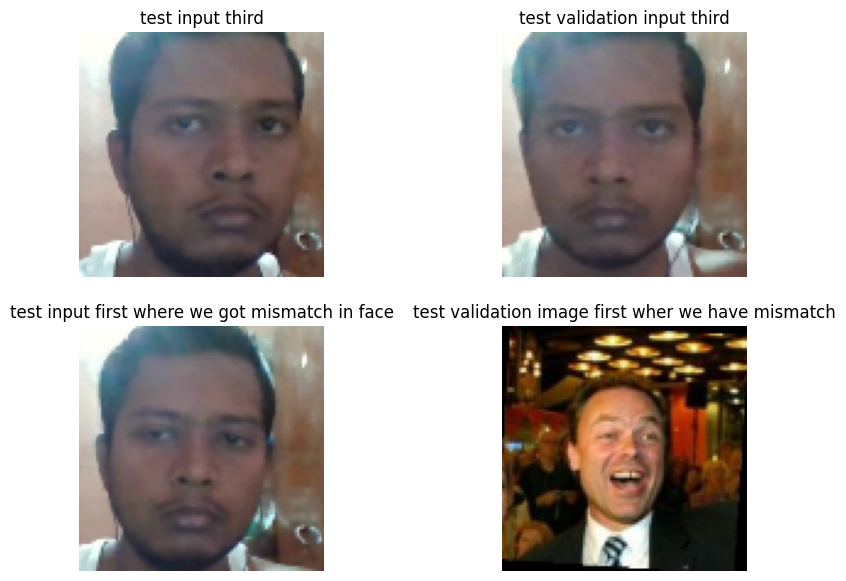

<Figure size 640x480 with 0 Axes>

In [78]:
fig = plt.figure(figsize=(10, 7))
rows = 2; columns = 2
fig.add_subplot(rows, columns, 1)
plt.axis('off')
plt.imshow(test_input[3])
plt.title('test input third')
# plot 2nd
fig.add_subplot(rows, columns, 2)
plt.axis('off')
plt.imshow(test_val[3])
plt.title('test validation input third')
# plot 3rd
fig.add_subplot(rows, columns, 3)
plt.axis('off')
plt.imshow(test_input[0])
plt.title('test input first where we got mismatch in face')
# plot 4th
fig.add_subplot(rows, columns, 4)
plt.axis('off')
plt.imshow(test_val[0])
plt.title('test validation image first wher we have mismatch')
plt.show()
plt.savefig('plot.jpg', format = 'jpg')

In [85]:
siamese_model.save('/content/drive/MyDrive/siameseModel.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [86]:
model = keras.models.load_model('siameseModel.h5',
                               custom_objects={'L1Dist':L1Dist,
                                               'BinaryCrossentropy':tf.losses.BinaryCrossentropy})